# Hands-on 1: Percepton Notebook (Tutorial)

**Alumno:** _Herrera Covarrubias Kevin Shalom_  
**Curso / Profesor:** _Clasificacion Inteligente de Datos / Jose Antonio Aviña Mendez_  



## Fundamentos de la técnica

El **Perceptrón** (Rosenblatt, 1958) es un **clasificador lineal** que aprende una **frontera recta** (hiperplano) para separar dos clases. Actualiza sus parámetros **solo cuando se equivoca**, y si los datos son linealmente separables, **converge**.


## Modelo Matemático del Perceptrón

Para una muestra $(\mathbf{x}_i, y_i)$ con $y_i\in\{-1,+1\}$, el modelo predice:

$$ \hat{y}_i = \operatorname{sign}(\mathbf{w}^\top\mathbf{x}_i + b). $$

Si $y_i(\mathbf{w}^\top\mathbf{x}_i + b) \le 0$, se actualiza con tasa $\eta$:

$$ \mathbf{w}\leftarrow\mathbf{w}+\eta\,y_i\,\mathbf{x}_i, \qquad b\leftarrow b+\eta\,y_i. $$

**Nota práctica:** en scikit-learn se usan etiquetas `0/1` y se maneja multiclase con *one-vs-rest*.


## Librerías/clases/funciones

- `sklearn.linear_model.Perceptron` (parámetros: `max_iter`, `tol`, `eta0`, `penalty`, `random_state`).
- `sklearn.preprocessing.StandardScaler` (escalado de features).
- `sklearn.pipeline.Pipeline` (encadena transformaciones y modelo).
- `sklearn.model_selection.train_test_split` (split estratificado).
- `sklearn.metrics` (`accuracy_score`, `confusion_matrix`, `classification_report`).


## Pipeline

### a) Feature Engineering
Cargamos **Social_Network_Ads.csv** y seleccionamos dos variables numéricas **`Age`** y **`EstimatedSalary`** como señales de entrada; la etiqueta es **`Purchased`** (0=no compra, 1=compra). Incluimos un **análisis estadístico** y un **gráfico de dispersión** por clase.


(400, 5)
    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0

Estadística básica:
                       mean           std      min       max
Age                 37.655     10.482877     18.0      60.0
EstimatedSalary  69742.500  34096.960282  15000.0  150000.0


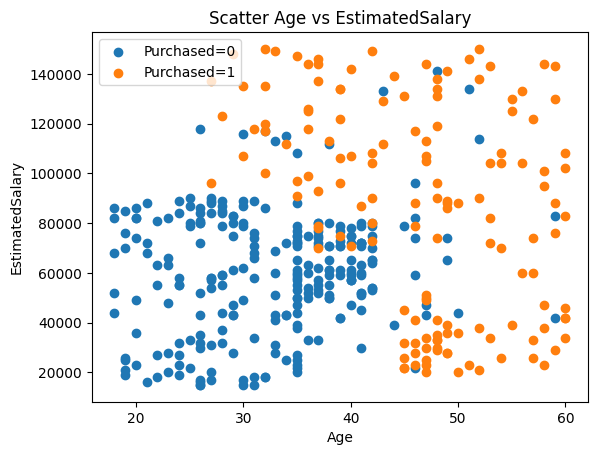

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
DATA_PATH = Path('/content/Social_Network_Ads.csv')
df = pd.read_csv(DATA_PATH)
print(df.shape)
print(df.head())

stats = df[['Age','EstimatedSalary']].describe().T[['mean','std','min','max']]
print("\nEstadística básica:\n", stats)

plt.figure()
for label, subset in df.groupby('Purchased'):
    plt.scatter(subset['Age'], subset['EstimatedSalary'], label=f'Purchased={label}')
plt.xlabel('Age'); plt.ylabel('EstimatedSalary'); plt.title('Scatter Age vs EstimatedSalary')
plt.legend(); plt.show()


### Explicación (Feature Engineering)
Primero, cargamos el dataset Social Network Ads.
Elegimos solo dos variables: la edad y el salario estimado de cada persona.
Estas son nuestras señales de entrada, porque es lógico pensar que a mayor edad y salario, la probabilidad de comprar puede cambiar.
Luego, mostramos un gráfico de dispersión para ver si hay alguna separación visual entre quienes compran y no compran.


### b) Model Selection
Usamos un **clasificador lineal** por su **simplicidad**, **rapidez** e **interpretabilidad**. Si el patrón de compra se correlaciona de manera aproximadamente lineal con edad/salario, el Perceptrón puede funcionar bien.

### c) Model Training (fit)
Entrenamos un `Pipeline` = `StandardScaler` → `Perceptron` con un 25 % para prueba (estratificado).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron

X = df[['Age','EstimatedSalary']].values
y = df['Purchased'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
perceptron_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", Perceptron(max_iter=2000, tol=1e-3, eta0=1.0, random_state=42))
])
perceptron_clf.fit(X_train, y_train)
print(perceptron_clf)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', Perceptron(max_iter=2000, random_state=42))])


### Explicación (Model Training — `fit`)
Después, entrenamos el modelo Perceptrón.
Este modelo intenta dibujar una línea recta (una frontera) que separe a los que compran de los que no.
Antes de eso, usamos un paso llamado StandardScaler, que ajusta los datos para que todas las variables tengan la misma escala y el modelo aprenda mejor.
En este caso, el modelo se entrenó correctamente, pero las clases están mezcladas, así que no logra una división perfecta.

### d) Prediction (función)
Creamos una función para clasificar un nuevo patrón `(Age, EstimatedSalary)` y mostrar la clase predicha.

In [ ]:
def predecir_compra(modelo, age, est_salary, nombres=('NoPurchase','Purchase')):
    import numpy as np
    v = np.array([[age, est_salary]])
    pred = int(modelo.predict(v)[0])
    try:
        dfc = modelo.decision_function(v)
        if getattr(dfc, 'shape', None) == (1,):
            print(f"decision_function: {float(dfc.item()):.4f}")
        else:
            print("decision_function:", dfc)
    except Exception:
        pass
    print(f"Predicción: {pred} -> {nombres[pred]}")
    return pred

_ = predecir_compra(perceptron_clf, X_test[0,0], X_test[0,1])


decision_function: 0.2617
Predicción: 1 -> Purchase


### Explicación (Prediction — función)
Creamos una función que recibe una edad y un salario y devuelve si el modelo cree que esa persona compraría o no.
También mostramos el valor de la función de decisión, que indica qué tan seguro está el modelo:
valores positivos son clase 1 (compra) y negativos son clase 0 (no compra).

### e) Model Evaluation
Calculamos **Accuracy** y **Matriz de Confusión**, además de un **reporte de clasificación**.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = perceptron_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
print("Matriz de Confusión:\n", cm)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, target_names=['NoPurchase','Purchase']))


Accuracy: 0.57
Matriz de Confusión:
 [[37 27]
 [16 20]]

Reporte de clasificación:
               precision    recall  f1-score   support

  NoPurchase       0.70      0.58      0.63        64
    Purchase       0.43      0.56      0.48        36

    accuracy                           0.57       100
   macro avg       0.56      0.57      0.56       100
weighted avg       0.60      0.57      0.58       100



### Explicación (Model Evaluation)
“Aquí calculamos el Accuracy, que mide qué porcentaje de predicciones fueron correctas.
El modelo obtuvo cerca de 57% de aciertos, lo cual indica que acierta un poco mejor que al azar.
La matriz de confusión nos muestra los aciertos y errores por clase: el modelo tiende a confundir varios casos de compradores y no compradores.
En resumen, la frontera lineal no logra separar bien ambos grupos, porque hay personas con edad y salario parecidos pero decisiones diferentes.”

## Conclusión de resultados
“El resultado muestra que el Perceptrón puede aprender una frontera, pero no siempre los datos son lineales.
En este caso, los compradores y no compradores se mezclan, así que una línea recta no basta.
Para mejorar el resultado, podríamos usar más variables (como género o historial de compras) o probar modelos más avanzados que no dependan de una separación recta, como un árbol de decisión o una red neuronal.”

## Referencias bibliográficas
- Rosebrock, A. (2021, 12 mayo). Implementing the Perceptron Neural Network with Python - PyImageSearch. PyImageSearch. https://pyimagesearch.com/2021/05/06/implementing-the-perceptron-neural-network-with-python
- Formulación matemática del Perceptrón | Interactive Chaos. (s. f.-b). https://interactivechaos.com/es/manual/tutorial-de-machine-learning/formulacion-matematica-del-perceptron
- Daniel. (2023, 30 octubre). Perceptrón: ¿qué es y para qué sirve? DataScientest. https://datascientest.com/es/perceptron-que-es-y-para-que-sirve
- Find Open Datasets and Machine Learning Projects | Kaggle. (s. f.-b). https://www.kaggle.com/datasets

